<a href="https://colab.research.google.com/github/ramanakshay/Optimal-Transport/blob/main/notebooks/dispersion_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Marginal Optimal Transport
1. Sinkhorn Solver
  * Generic Sinkhorn
  * Auto Sinkhorn
  * Random Sinkhorn
2. Multi-marginal Sinhorn on 1D Gaussian Distributions
  * Cost Tensor
  * Visualising the Coupling Tensor
3. Comparison of Running Times

## Multi-marginal Optimal Transport with Entropic Regularisation

Let $ n $ be the number of marginals and $ s $ be the size of 1D probability distributions.

The matrix $ A $ of size $ n \times s $ such that each row $ A_i $ is a 1D probability distribution of size $ s $.

$$ \sum_{j=0}^s{A_{ij}} = 1 \space \forall i \in ℕ_{n} \$$

The cost tensor $ C $ and coupling tensor $ P $ is a tensor of size $ s^n $. The optimal transport problem is defined as:

$$OT_C(A) := \min \left \langle  C,P\right \rangle + ɛH(P)$$

$H(P)$ is the discrete entropy for a coupling tensor with 3 marginals is defined as:

$$ H(P) := - \sum_{ijk}{P_{ijk}\left ( \log{P_{ijk} - 1} \right )} $$

## Import Libraries

In [ ]:
!pip install pot  # Pip Installs Packages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 4.2 MB/s 


In [ ]:
user = 'ramanakshay'
repo = 'Optimal-Transport'

url = f"git+https://github.com/{user}/{repo}.git"
!pip install --upgrade {url}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ramanakshay/Optimal-Transport.git to /tmp/pip-req-build-oau8ptfs
  Running command git clone -q https://github.com/ramanakshay/Optimal-Transport.git /tmp/pip-req-build-oau8ptfs
  Created wheel for utils: filename=utils-0.1.0-py3-none-any.whl size=3084 sha256=aaf9cfa439ae824552d7385fd8c6ce5e44b73e42ccc26458ae4c3dd543529750
  Stored in directory: /tmp/pip-ephem-wheel-cache-gtig112n/wheels/83/c1/b0/8b4aae55c1a6c852e5e98d2e522e0c76c069f92e4d3885455f
Successfully built utils


In [ ]:
import numpy as np 

import matplotlib.pyplot as plt # plotting

import ot  # ot
import ot.plot
from prettytable import PrettyTable

from tqdm import tqdm #progress bar
from IPython.display import clear_output

import time # measure time
from numpy import random

In [ ]:
from utils.plot import plot_matrix,plot_2d_map
from utils.dist import find_cost_tensor

## Sinkhorn Solver Class

The scaling vectors are stored in a matrix $ U $ of size $ n \times s $. They can be initialised to ones or random values. Three versions of sinkhorn have been implemented:

1. **Generic Sinkhorn** \\
  Input: ɛ, n_iter, initialisation type \\
  Output: $P$ tensor \\
  Stopping Time: Number of Iterations (n_iter)

2. **Auto Sinkhorn** \\
  Input: ɛ, error, initialisation type \\
  Output: $P$ tensor \\
  Stopping Time:
  $ \left | \sum_{ℕ_{n} - \{i\}}{P - A_{i}} \right | \leq $ error $\space \forall i \in ℕ_{n} $

3. **Random Sinkhorn** \\
  Update k scaling vectors at a time. (faster Iteration but takes more time to converge) \\
  Input: ɛ, error, k,initialisation type \\
  Output: $P$ tensor \\
  Stopping Time:
  $ \left | \sum_{ℕ_{n} - \{i\}}{P - A_{i}} \right | \leq $ error $\space \forall i \in ℕ_{n} $

In [ ]:
class SinkhornSolver(object):
  def __init__(self,A,C):
    self.A = A
    self.C = C
    self.n = A.shape[0]
    self.size = A.shape[1]
  
  def initialise(self,initial):
    if (initial == "ones"):
      return np.ones((self.n,self.size))
    elif (initial == "random"):
      return random.rand(self.n,self.size)
    else:
      raise ValueError("Invalid Argument: " + initial + " is not a valid type.")

#-----------------------------HELPER FUNCTIONS---------------------------------#
  def multiply(self,P,U,i):
    shape = [1]*self.n
    shape[i] = self.size
    shape = tuple(shape)
    temp = U[i].reshape(shape)
    return P * temp

  def divide(self,P,U,i):
    shape = [1]*self.n
    shape[i] = self.size
    shape = tuple(shape)
    temp = U[i].reshape(shape)
    return P / temp

  def sum_to_vector(self,P,i):
    axes = list(range(n))
    axes.remove(i)
    axes = tuple(axes)
    return np.sum(P,axis = axes)

#-----------------------------GENERIC SINKHORN---------------------------------#

  def generic_sinkhorn(self,epsilon,niter,initial = "ones"):
    U = self.initialise(initial)
    K = np.exp(-self.C/epsilon)
    P = np.copy(K)

    #initialise P
    for i in range(self.n):
      P = self.multiply(P,U,i)
    
    #loop
    for it in tqdm(range(niter)):
      for i in range(self.n):
        P = self.divide(P,U,i)
        U[i] = self.A[i] / self.sum_to_vector(P,i)
        P = self.multiply(P,U,i)
    
    #return coupling
    return P

#--------------------------------AUTO SINKHORN---------------------------------#

  def auto_sinkhorn(self,epsilon,error,initial = "ones"):
    U = self.initialise(initial)
    K = np.exp(-self.C/epsilon)
    P = np.copy(K)

    #initialise P
    for i in range(self.n):
      P = self.multiply(P,U,i)
    
    #loop
    iter = 0
    while(True):
      for i in range(self.n):
        P = self.divide(P,U,i)
        U[i] = self.A[i] / self.sum_to_vector(P,i)
        P = self.multiply(P,U,i)

      #marginal condition
      flag = True
      max_error = -1
      for i in range(self.n):
        if (np.any(abs(self.sum_to_vector(P,i) - self.A[i]) >= error)):
          flag = False
        clear_output(wait = True)
        max_error = max(max_error,np.max(abs(self.sum_to_vector(P,i) - self.A[i])))
      if(flag):
        break

      print("Maximum Error:",max_error)
      print("#Iterations:",iter)
      
      iter += 1

    #return coupling  
    return P

#--------------------------------RANDOM SINKHORN-------------------------------#

  def random_sinkhorn(self,epsilon,error,k = None,initial = "ones"):
    if (k == None):
      k = self.n

    U = self.initialise(initial)
    K = np.exp(-self.C/epsilon)
    P = np.copy(K)

    #initialise P
    for i in range(self.n):
      P = self.multiply(P,U,i)
    
    #loop
    iter = 0
    while(True):
      for i in random.choice(self.n, k, replace=False):
        P = self.divide(P,U,i)
        U[i] = self.A[i] / self.sum_to_vector(P,i)
        P = self.multiply(P,U,i)

      #marginal condition
      flag = True
      max_error = -1
      for i in range(self.n):
        if (np.any(abs(self.sum_to_vector(P,i) - self.A[i]) >= error)):
          flag = False
        clear_output(wait = True)
        max_error = max(max_error,np.max(abs(self.sum_to_vector(P,i) - self.A[i])))
      if(flag):
        break
      
      print("Maximum Error:",max_error)
      print("#Iterations:",iter)

      iter += 1

    #return coupling  
    return P

#------------------------------------------------------------------------------#

## Multi-marginal Sinkhorn on 1D Gaussian Distributions

### Gaussian Distribution

$$ f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left (  \frac{x-\mu}{\sigma}\right )^2} $$

where $\mu$ is the mean and $\sigma$ is the standard deviation of the distribution.

In [ ]:
def gaussian_mix(n,mu,std,scale = None):
  assert len(mu) == len(std)
  if scale == None:
    scale = [1]*len(mu)
  x = np.arange(n, dtype = np.float64)
  h = 0
  for i in range(len(mu)):
    h += np.exp(-(x - mu[i]) ** 2 / (2 * std[i] ** 2))*scale[i]
  return h / h.sum()

def dispersion_density(n,R):
  return gaussian_mix(n,[n//2 + R/2,n//2 - R/2],[n/16,n/16],[1,2])

In [ ]:
n = 2
size = 200

A = np.empty((n,size), float)
# All marginals are the same
for i in range(n):
  A[i] = dispersion_density(size,0)

x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

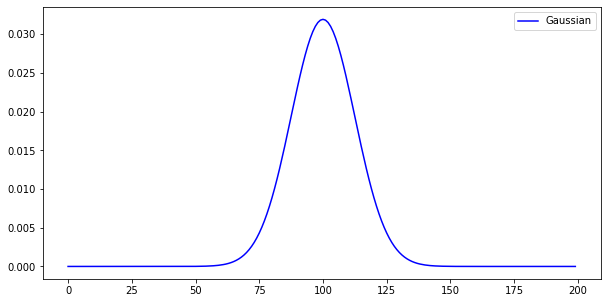

In [ ]:
#Plot distributions
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b',label = 'Gaussian')
plt.legend()
plt.show()

### Cost Tensor

$$ C = \sum_{1 \leq i < j \leq n}{\frac {1}{\left | 1 + (r_i - r_j) \right | }} $$

(100, 100)


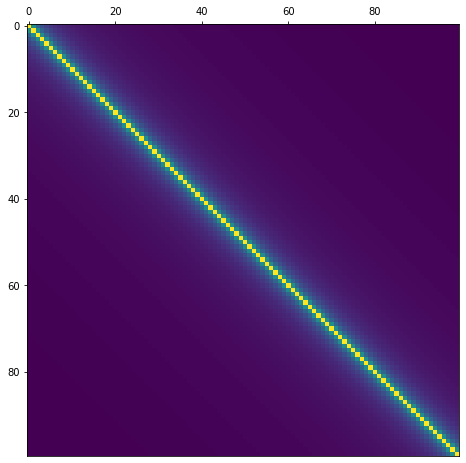

In [ ]:
C = find_cost_tensor(X)
print(C.shape)
#Cm = np.sum(C,axis = (2))
plot_matrix(C,x,x)

### Coupling Tensor

In [ ]:
solver = SinkhornSolver(A,C)

In [ ]:
P = solver.auto_sinkhorn(1e-3,1e-6,initial="random")

Maximum Error: 1.0206217642277915e-06
#Iterations: 322


In [ ]:
#P = solver.random_sinkhorn(1e-3,1e-6,k = 3,initial="random")

In [ ]:
#P = solver.generic_sinkhorn(10,100)

100%|██████████| 10/10 [01:06<00:00,  6.68s/it]


#### Coupling Projection Matrix

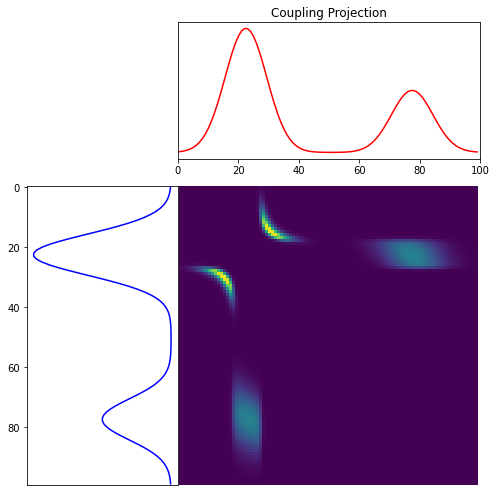

In [ ]:
# Pm = np.sum(P,axis = (2))

plt.figure(figsize=(7, 7))
ot.plot.plot1D_mat(A[0], A[1], P, 'Coupling Projection')

In [ ]:
V = np.sum(C*P)
x = [] # R values
y = [] # V values

for R in range(0,100,5):
  x.append(R)
  #...
  y.append(V)

  #Plot distributions
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.show()

#### Comparing Approximate Distribution and Exact Distribution

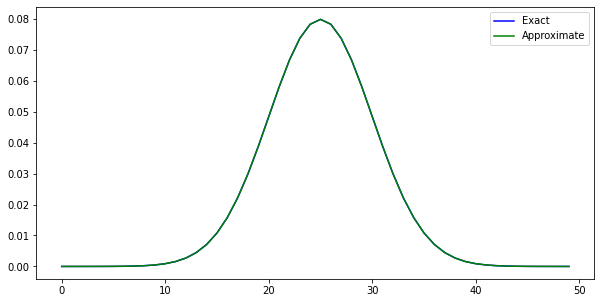

In [ ]:
Pv = np.sum(P,axis = (1,2,3,4))
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b', label='Exact')
plt.plot(x, Pv, 'g', label='Approximate')
plt.legend()
plt.show()

#### 3D Plots

In [ ]:
from mpl_toolkits import mplot3d

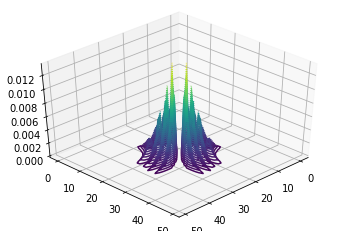

In [ ]:
X, Y = np.meshgrid(x, x)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.contour3D(X, Y, Pm, 50)
clear_output()
ax.view_init(40, 45)

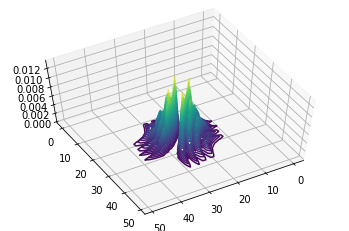

In [ ]:
ax.view_init(60, 60)
fig

### Total Cost

In [ ]:
OT = np.sum(C*P)
print('Total Cost:', OT)

Total Cost: 1.6452483634783885


## Comparison

### Epsilon vs. OT Cost

+---------+--------+
| epsilon |   W    |
+---------+--------+
|   100   | 0.7578 |
|   10.0  | 0.7465 |
|   1.0   | 0.6618 |
|   0.1   | 0.4804 |
|   0.01  | 0.4175 |
|  0.001  | 0.4109 |
+---------+--------+


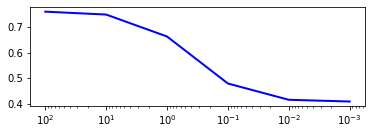

In [ ]:
n = 3
size = 50

table = PrettyTable()
table.field_names = ["epsilon", "W"]


A = np.empty((n,size), float)
for j in range(n):
  A[j] = gaussian_mix(size,[25],[5],[1])

x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

C = find_cost_tensor(X)

solver = SinkhornSolver(A,C)

epsilon = 100
x = []
y = []
while(epsilon >= 0.001):
  P = solver.auto_sinkhorn(epsilon,1e-5,initial="ones")
  W = np.sum(C*P)
  x.append(epsilon)
  y.append(W)
  table.add_row([epsilon,round(W,4)])
  clear_output(wait = True)
  epsilon  /= 10


print(table)

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(x,y, color='blue', lw=2)
ax.set_xscale('log')
ax.invert_xaxis()
plt.show()

### Running time vs. Number of Marginals

In [ ]:
table = PrettyTable()
table.field_names = ["N", "t(s), eps = 100","t(s), eps = 10","t(s), eps = 1","t(s), eps = 0.1","t(s), eps = 0.01"]

marginals = 5
size = 50
for n in range(2,marginals+1):
  A = np.empty((n,size), float)
  for j in range(n):
    A[j] = gaussian_mix(size,[25],[5],[1])

  x = np.array([[i,] for i in range(size)]) # defining the space
  X = np.tile(x.T,(n,1))

  C = find_cost_tensor(X)

  solver = SinkhornSolver(A,C)

  epsilon = 100
  row = [n]
  while(epsilon >= 0.01):
    start = time.time()
    solver.auto_sinkhorn(epsilon,1e-5,initial="ones")
    end = time.time()
    t = end - start
    row.append(round(t,3))
    clear_output(wait = True)
    epsilon /= 10

  del [A,C,solver] # clear memory
  table.add_row(row)

print(table)

+---+-----------------+----------------+---------------+-----------------+------------------+
| N | t(s), eps = 100 | t(s), eps = 10 | t(s), eps = 1 | t(s), eps = 0.1 | t(s), eps = 0.01 |
+---+-----------------+----------------+---------------+-----------------+------------------+
| 2 |      0.021      |     0.011      |     0.018     |      0.027      |      0.183       |
| 3 |      0.073      |     0.037      |     0.071     |      0.152      |      1.152       |
| 4 |      0.776      |     0.947      |     1.485     |      4.399      |      23.659      |
| 5 |      31.224     |     37.334     |     57.066    |     198.764     |     1525.699     |
+---+-----------------+----------------+---------------+-----------------+------------------+
